# Regex pour les logs Apache

In [10]:
import re
log = '65.88.2.5 - - [23/Apr/2010:11:22:43 -0700] "GET /feed/ HTTP/1.1" 200 16605 "-" "Apple-PubSub/65.12.1" g2TqxwoAAQ4AAEBnApAAAAAB 1288590'
re_apache = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - \[[^\]]*\] "(GET|POST|DELETE|PUT|CONNECT) ([^ ]*) ([^"]*)" (\d{3}) (\d+) "([^\"]*)" "([^\"]*)" ([^ ]*) (\d*)'

regex_du_prof = r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}) - - \[[^\]]*\] \"(GET|PUT|POST|DELETE|CONNECT|TRACE) ([^ ]*) [^"]*" (\d{1,3}) (\d*|-) "[^"]*" "([^"]*)" [^ ]* (\d*|-)'

re_apache_serialized = re.compile(re_apache)

m = re_apache_serialized.match(log)
if m:
    print(m.groups())

('65.88.2.5', 'GET', '/feed/', 'HTTP/1.1', '200', '16605', '-', 'Apple-PubSub/65.12.1', 'g2TqxwoAAQ4AAEBnApAAAAAB', '1288590')


In [36]:
from typing import Tuple, List

result: List[Tuple] = []
with open('./sanitized_log/apache2/www-access.log', 'r') as f:
    for line in f.readlines():
        m = re_apache_serialized.match(line.strip())
        if m:
            result.append(m.groups())
result[0]

('10.0.1.2',
 'GET',
 '/feed/',
 'HTTP/1.1',
 '200',
 '16605',
 '-',
 'Apple-PubSub/65.12.1',
 'C4nE4goAAQ4AAEP1Dh8AAAAA',
 '3822005')

In [37]:
import pandas as pd

df = pd.DataFrame(result, columns=['ip_source', 'method', 'url', 'http_version', 'status_code', 'request_size', 'refers', 'user_agent', '???', 'response_size'])

df[['ip_source', 'url']]

,ip_source,url
0,10.0.1.2,/feed/
1,10.0.1.2,/feed/
2,10.0.1.2,/feed/
3,10.0.1.2,/feed/
4,123.4.59.174,http://proxyjudge1.proxyfire.net/fastenv
...,...,...
335,10.0.1.2,/feed/
336,10.0.1.2,/feed/
337,10.0.1.2,/feed/
338,10.0.1.2,/feed/


On veut recuperer la liste des url accedees par chaque ip.

In [40]:
ip_source = df['ip_source'].unique()
# ip_source = set(ip_source)

from collections import Counter

ip_url_count = [(ip, Counter(list(df[df['ip_source'] == ip]['url']))) for ip in ip_source]

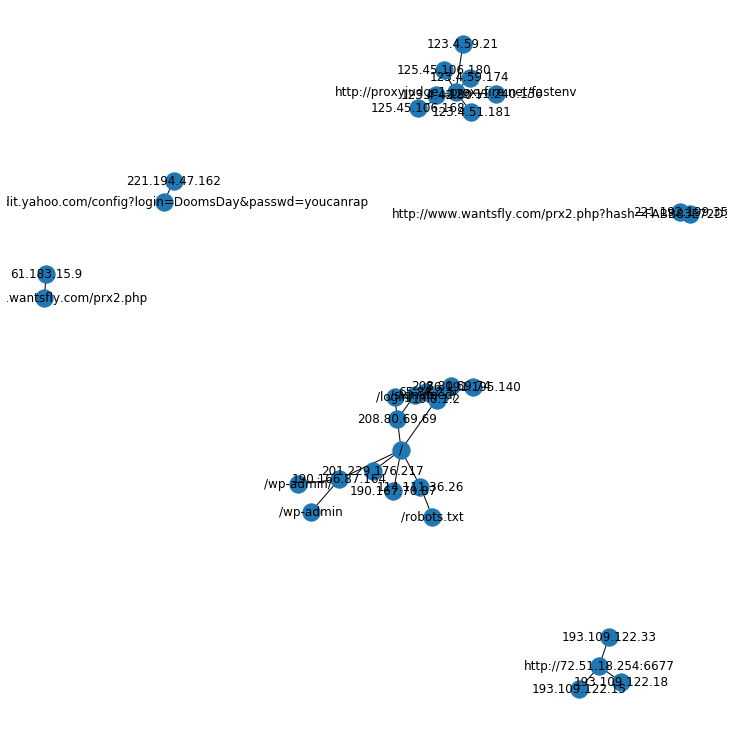

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
g = nx.Graph()
for ip, c in ip_url_count:
    for k, v in c.items():
        g.add_edge(ip, k, weight=v)
pos = nx.spring_layout(g)
plt.figure(3, figsize=(10, 10))
nx.draw(g, pos, with_labels=True)

In [50]:
import community

partition = community.best_partition(g)
partition

{'10.0.1.2': 0,
 '/feed/': 0,
 '/': 1,
 '/login/': 1,
 '123.4.59.174': 2,
 'http://proxyjudge1.proxyfire.net/fastenv': 2,
 '221.192.199.35': 3,
 'http://www.wantsfly.com/prx2.php?hash=FABB83E72D135F1018046CC4005088B36F8D0BEDCEA7': 3,
 '190.167.70.87': 1,
 '201.229.176.217': 1,
 '208.80.69.69': 1,
 '/signup/': 4,
 '208.80.69.74': 0,
 '76.191.195.140': 0,
 '193.109.122.33': 5,
 'http://72.51.18.254:6677': 5,
 '221.194.47.162': 6,
 'http://edit.yahoo.com/config?login=DoomsDay&passwd=youcanrap': 6,
 '125.45.106.180': 2,
 '114.111.36.26': 1,
 '/robots.txt': 1,
 '123.4.59.21': 2,
 '125.45.106.168': 2,
 '123.4.42.80': 2,
 '190.166.87.164': 1,
 '/wp-admin': 1,
 '/wp-admin/': 1,
 '61.183.15.9': 7,
 'http://www.wantsfly.com/prx2.php': 7,
 '65.88.2.5': 4,
 '123.11.240.130': 2,
 '193.109.122.18': 5,
 '123.4.51.181': 2,
 '193.109.122.15': 5}